In [1]:
import numpy as np
from gensim.models import Word2Vec
import snap
import operator
import snap
from scipy.stats import binom
import matplotlib.pyplot as plt
import scipy

# Machine learning packages

# Supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Unsupervised learning (i.e. clustering)
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

# Clustering assessment metrics(for unknown ground truth)
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

/anaconda3/envs/python2/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [3]:
# Load the embeddings from memory
neutral_model = Word2Vec.load_word2vec_format("../node2vec_embeddings/companies_final_p1_q1.emd")
print len(neutral_model.vocab)

10298


In [4]:
# These are all of the acquired companies we know about
acquired_companies = set(np.load("../acquired_companies.npy"))

In [5]:
node_id_to_value = np.load("../../graphs/investors_to_companies_directed/node_id_to_value.npy").item()
print len(node_id_to_value)

21945


In [8]:
# Now we find the overlap between companies in our graph and the set of acquired companies
FIn = snap.TFIn("../../graphs/investors_to_companies_directed/investors_to_companies_directed_folded.graph")
G = snap.TUNGraph.Load(FIn)

companies_in_graph = set()
for EI in G.Edges(): 
    curr_src_id = EI.GetSrcNId()
    curr_dst_id = EI.GetDstNId()
    companies_in_graph.add(node_id_to_value[curr_src_id])
    companies_in_graph.add(node_id_to_value[curr_dst_id])
    
# These are the acquired companies in our folded graph
acquired_companies_in_graph = companies_in_graph.intersection(acquired_companies)

acquired_companies_in_graph_by_id = []
value_to_node_id = {v: k for k, v in node_id_to_value.iteritems()}
for company in acquired_companies_in_graph:
    acquired_companies_in_graph_by_id.append(value_to_node_id[company])
    
not_acquired_companies_in_graph = companies_in_graph.difference(acquired_companies)
not_acquired_companies_in_graph_by_id = []
for company in not_acquired_companies_in_graph:
    not_acquired_companies_in_graph_by_id.append(value_to_node_id[company])

In [10]:
# Returns train and test sets with fraction train_frac 
# of the total number of datapoints in the train set
def getData(model, train_frac):
    # Use node2vec and logistic regression to make predictions
    node_2_vec_embedding_dimension = 128

    # Create train dataset
    train_companies = set([])
    # Randomly assign train test
    for company in companies_in_graph: 
        if np.random.rand() < train_frac: train_companies.add(company)
              
    test_companies = companies_in_graph.difference(train_companies)

    train_X = np.zeros((len(train_companies), node_2_vec_embedding_dimension))
    train_Y = np.zeros((len(train_companies),))

    train_companies = list(train_companies)
    for i in range(len(train_companies)):
        company_id = value_to_node_id[train_companies[i]]
        company_embedding = model[str(company_id)]
        train_X[i] = company_embedding
        if company_id in acquired_companies_in_graph_by_id:
            train_Y[i] = 1
        else:
            train_Y[i] = 0

    # Create test dataset
    test_X = np.zeros((len(test_companies), node_2_vec_embedding_dimension))
    test_Y = np.zeros((len(test_companies),))

    test_companies = list(test_companies)
    for i in range(len(test_companies)):
        company_id = value_to_node_id[test_companies[i]]
        company_embedding = model[str(company_id)]
        test_X[i] = company_embedding
        if company_id in acquired_companies_in_graph_by_id:
            test_Y[i] = 1
        else:
            test_Y[i] = 0 
            
    return train_X, train_Y, test_X, test_Y

In [11]:
def assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model):
    train_predictions = fitted_model.predict(train_X)
    test_predictions = fitted_model.predict(test_X)
    print "Train confusion matrix (rows correspond to true labels)"
    print confusion_matrix(train_Y, train_predictions, labels=[0, 1])
    print "Test confusion matrix (rows correspond to true labels)"
    print confusion_matrix(test_Y, test_predictions, labels=[0, 1])

    print "Train score"
    print fitted_model.score(train_X, train_Y)
    print "Test score"
    print fitted_model.score(test_X, test_Y)
    print ""

In [15]:
def logistic_regression(train_X, train_Y, test_X, test_Y, class_weight):
    # Weight the less common class more heavily
    # For the confustion matrix, rows correspond to true labels and columns to predicted labels
    fitted_model = LogisticRegression(class_weight={0:1, 1:2}).fit(train_X, train_Y)
    print "Successfully fitted logistic regression classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [16]:
# Now we'll try using a decision tree
def decision_tree_classifier(train_X, train_Y, test_X, test_Y):
    fitted_model = DecisionTreeClassifier().fit(train_X, train_Y)
    print "Successfully fitted decision tree classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [24]:
# No surprise that the neural net overfit
# Let's now try using KNN
def knn_classifier(train_X, train_Y, test_X, test_Y, k):
    fitted_model = KNeighborsClassifier(n_neighbors=10).fit(train_X, train_Y)
    print "Successfully fitted KNN classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [21]:
# Finally, we'll give the random forest a go
# This model turns a bunch of weaker decision
# models into a more powerful ensemble model
def random_forest_classifier(train_X, train_Y, test_X, test_Y):
    fitted_model = RandomForestClassifier().fit(train_X, train_Y)
    print "Successfully fitted random forest classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [22]:
# Looks like logistic regression mostly predicts not acquired the vast majority of the time as expected
# Let's see if a simple neural net can do any better
def mlp_classifier(train_X, train_Y, test_X, test_Y):
    fitted_model = MLPClassifier().fit(train_X, train_Y)
    print "Successfully fitted MLP classifier"
    assess_supervised_classifier(train_X, train_Y, test_X, test_Y, fitted_model)

In [25]:
train_X, train_Y, test_X, test_Y = getData(neutral_model, 0.8)

logistic_regression(train_X, train_Y, test_X, test_Y, {0:1, 1:2})
mlp_classifier(train_X, train_Y, test_X, test_Y)
knn_classifier(train_X, train_Y, test_X, test_Y, 10)
decision_tree_classifier(train_X, train_Y, test_X, test_Y)
random_forest_classifier(train_X, train_Y, test_X, test_Y)

Successfully fitted logistic regression classifier
Train confusion matrix (rows correspond to true labels)
[[6930  122]
 [1070   85]]
Test confusion matrix (rows correspond to true labels)
[[1757   41]
 [ 276   17]]
Train score
0.854758133301
Test score
0.848397895744

Successfully fitted MLP classifier
Train confusion matrix (rows correspond to true labels)
[[7039   13]
 [ 637  518]]
Test confusion matrix (rows correspond to true labels)
[[1725   73]
 [ 268   25]]
Train score
0.920799317656
Test score
0.836920133907

Successfully fitted KNN classifier
Train confusion matrix (rows correspond to true labels)
[[7044    8]
 [1139   16]]
Test confusion matrix (rows correspond to true labels)
[[1792    6]
 [ 293    0]]
Train score
0.860241257463
Test score
0.857006217121

Successfully fitted decision tree classifier
Train confusion matrix (rows correspond to true labels)
[[7052    0]
 [   0 1155]]
Test confusion matrix (rows correspond to true labels)
[[1504  294]
 [ 225   68]]
Train score


Also use k means to see how an unsupervised model performs

In [41]:
def assess_clustering_model(fitted_model, train_X, test_X=None):
    train_is_whole_dataset = True if test_X == None else False
    
    train_cluster_assignments = fitted_model.predict(train_X)
    test_cluster_assignments = None if train_is_whole_dataset else fitted_model.predict(test_X)
    
    # Compute the mean silhoutte score across all samples
    # For silhouette scores, the best value is 1 and the worst value is -1
    # Values near 0 indicate overlapping clusters
    train_silhouette_score = silhouette_score(train_X, train_cluster_assignments)
    test_silhouette_score = None if train_is_whole_dataset else silhouette_score(test_X, test_cluster_assignments)
    print "Train silhouette score:" 
    print train_silhouette_score
    print "Test silhouette score:"
    print test_silhouette_score

    # Compute the mean Calinski-Harabasz index for all samples
    # For Calinski-Harabasz, the higher the better
    train_ch_score = calinski_harabaz_score(train_X, train_cluster_assignments)
    test_ch_score = None if train_is_whole_dataset else calinski_harabaz_score(test_X, test_cluster_assignments)
    print "Train Calinski-Harabasz score:"
    print train_ch_score
    print "Test Calinski-Harabasz score:"
    print test_ch_score
    print ""
    return test_silhouette_score

In [42]:
# Let's assume we don't know anything about the companies
# We'll use k-means to cluster their node2vec embeddings
def k_means(train_X, test_X, k):
    fitted_model = KMeans(n_clusters=k).fit(train_X)
    print "Successfully fitted K Means"
    return assess_clustering_model(fitted_model, train_X, test_X)

Successfully fitted K Means


/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


Train silhouette score:
0.218004064288
Test silhouette score:
0.216399410349
Train Calinski-Harabasz score:
799.414622748
Test Calinski-Harabasz score:
186.16589252

Successfully fitted K Means
Train silhouette score:
0.0830004570238
Test silhouette score:
0.083804011431
Train Calinski-Harabasz score:
643.353967995
Test Calinski-Harabasz score:
159.685918661

Successfully fitted K Means
Train silhouette score:
0.0660346060079
Test silhouette score:
0.0646879953838
Train Calinski-Harabasz score:
498.952839408
Test Calinski-Harabasz score:
122.731835435

Successfully fitted K Means
Train silhouette score:
0.0653414537493
Test silhouette score:
0.0641275543549
Train Calinski-Harabasz score:
419.558683359
Test Calinski-Harabasz score:
103.246569181

Successfully fitted K Means
Train silhouette score:
0.067100625408
Test silhouette score:
0.0675694526381
Train Calinski-Harabasz score:
359.617597621
Test Calinski-Harabasz score:
88.8960821173

Successfully fitted K Means
Train silhouette sco

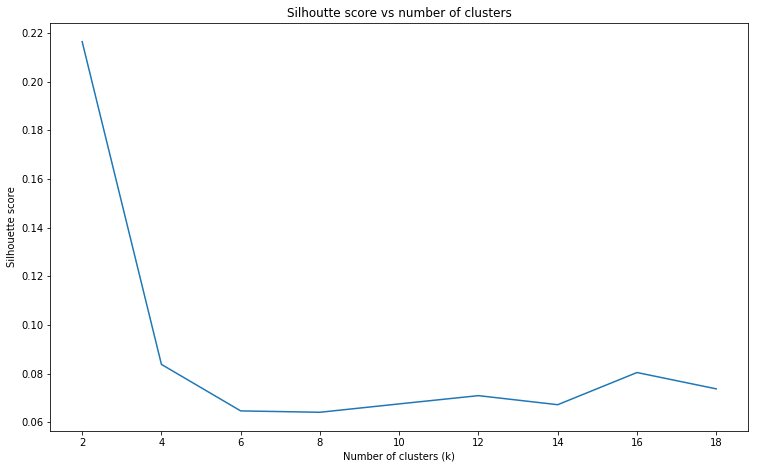

In [46]:
fig = plt.figure(figsize=(12.5, 7.5))

train_X, train_Y, test_X, test_Y = getData(neutral_model, 0.8)

sil_scores = []
x_vals = []
for k in range(2, 20, 2):
    sil_scores.append(k_means(train_X, test_X, k))
    x_vals.append(k)

plt.plot(x_vals, sil_scores)
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhoutte score vs number of clusters")
plt.show()

fig.savefig("/Users/samschwager 1/Desktop/k_means.png", dpi=fig.dpi)